In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [ ]:
'''
In this fourth round of Prosperity a new luxury product is introduced: `MAGNIFICENT MACARONS`. `MAGNIFICENT MACARONS` are a delicacy and their value is dependent on all sorts of observable factors like hours of sun light, sugar prices, shipping costs, in- & export tariffs and suitable storage space. Can you find the right connections to optimize your program? 

Position limits for the newly introduced products:

- `MAGNIFICENT_MACARONS`: 75
- Conversion Limit for `MAGNIFICENT_MACARONS` = 10
'''

'''
1. ConversionObservation (detailed in “[Writing an Algorithm in Python](https://www.notion.so/Writing-an-Algorithm-in-Python-17be8453a09381988c6ed45b1b597049?pvs=21)” under E-learning center) shows quotes of `MAGNIFICENT_MACARONS` offered by the chefs from Pristine Cuisine
2. To purchase 1 unit of `MAGNIFICENT_MACARONS` from Pristine Cuisine, you will purchase at askPrice, pay `TRANSPORT_FEES` and `IMPORT_TARIFF`
3. To sell 1 unit of `MAGNIFICENT_MACARONS` to Pristine Cuisine, you will sell at bidPrice, pay `TRANSPORT_FEES` and `EXPORT_TARIFF`
4. You can ONLY trade with Pristine Cuisine via the conversion request with applicable conditions as mentioned in the wiki
5. For every 1 unit of `MAGNIFICENT_MACARONS` net long position, storage cost of 0.1 Seashells per timestamp will be applied for the duration that position is held. No storage cost applicable to net short position


we have to already be long / short earlier to be able to convert
can only convert at most to neutral at 0, not more than that

AKA we buy / sell from our own island
if position mispriced we sell to other island easily


Official Hint:

It was well understood lore in Archipelago that low sunlight index can impact sugar and MACARON production negatively causing prices to rise due to panic among residents. However, ArchiResearchers have identified existence of a CriticalSunlightIndex (CSI).

If sunlightindex goes below this CSI with an anticipation to remain under this critical level for a long period of time, sugar and MACARON prices can increase by substantial amount with a strong correlation.

When sunlightindex is above this CSI, Sugar and MACARON prices tend to trade around their respective fair values and demonstrates market supply-demand dynamics.

Can you find this CSI and use it to trade better than ever and make your island prosper? All the best!

'''

'''
Ideas:

- regression extrapolate on past sunlight trend and we'll soon know based on slope and rate of change per timestamp whehter we're heading below this threshold
- if we expect this, get into huge buy position and sell at the top
- if sunlight goes below this CSI then strong positive correlation between sugar prices and macaron
    - in this case we just do pairs trading with mean reversion when they deviate by a lot
- if above this csi, normal market supply-demand
    - normal market take / make used in kelp

'''


class Product:
    MACARONS = 'MAGNIFICENT_MACARONS'


In [43]:
prices = pd.concat([pd.read_csv(f'round4/prices_round_4_day_{i}.csv', sep=';') for i in range(1, 4)], ignore_index=True)
trades = pd.concat([pd.read_csv(f'round4/trades_round_4_day_{i}_nn.csv', sep=';') for i in range(1, 4)], ignore_index=True)
observations = []
for day in range(1, 4):
    odf = pd.read_csv(f'round4/observations_round_4_day_{day}.csv')
    odf['day'] = day
    observations.append(odf)
observations = pd.concat(observations, ignore_index=True)
observations = observations.rename({'bidPrice': 'islandBid', 'askPrice': 'islandAsk'}, axis=1)

In [44]:
macarons = prices[prices['product'] == Product.MACARONS].reset_index(drop=True).copy()

In [45]:
mk = observations.merge(macarons, on=['day', 'timestamp'])

In [46]:
mk['time'] = mk['timestamp'] + (mk['day'] - 1) * 1_000_000

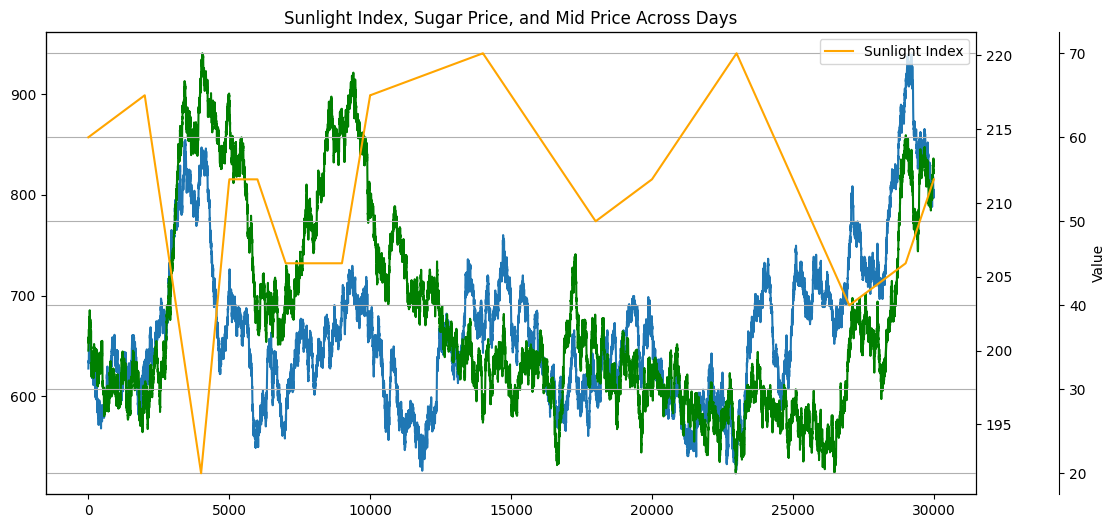

In [59]:
def plot_components(comp1, comp2, comp3):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    # Offset the third axis to avoid overlap
    ax3.spines['right'].set_position(('outward', 60))
    ax1.plot(comp1.index, comp1, label='Mid Price')
    ax2.plot(comp2.index, comp2, label='Sugar Price', color='green')
    ax3.plot(comp3.index, comp3, label='Sunlight Index', color='orange')
    plt.xlabel('time')
    plt.ylabel('Value')
    plt.title('Sunlight Index, Sugar Price, and Mid Price Across Days')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# plot_components(mk)
plot_components(mk['mid_price'], mk['sugarPrice'], mk['sunlightIndex'])

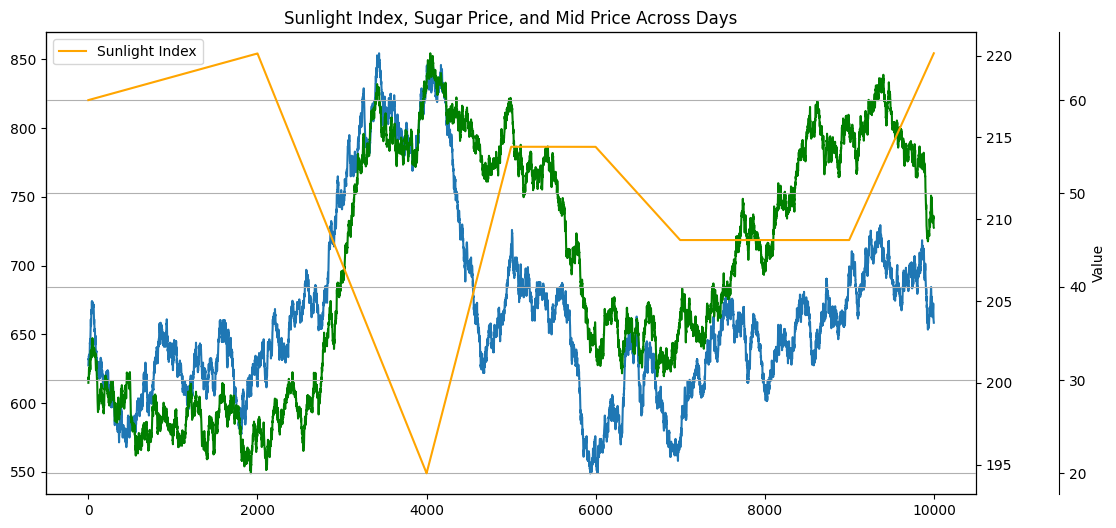

In [ ]:
df = mk[mk['day'] == 1].copy()

plot_components(df['mid_price'], df['sugarPrice'], df['sunlightIndex'])

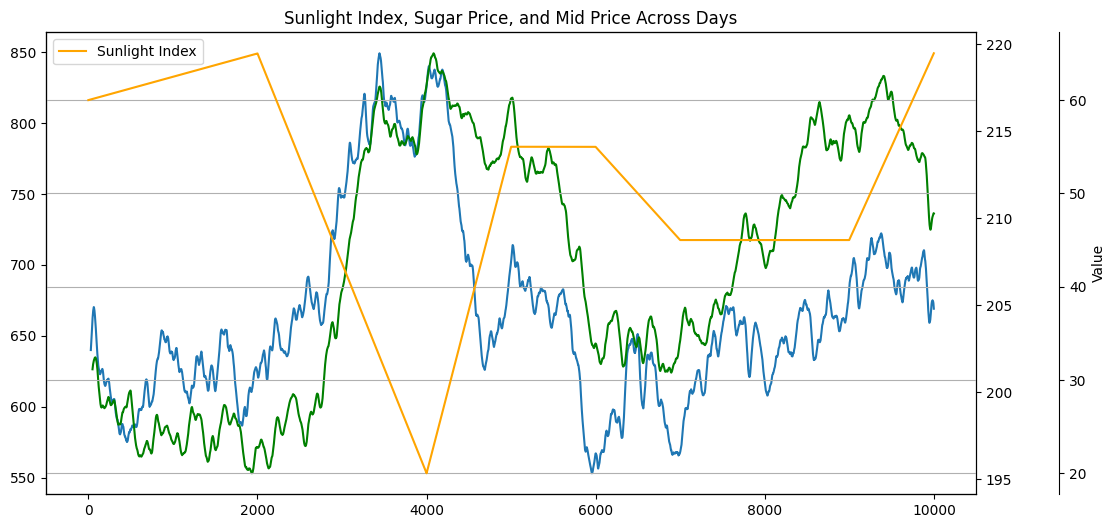

In [137]:
data = df.iloc[1990:2100]
data = df
sma = data['mid_price'].rolling(30).mean()
mid_diff = sma.diff(periods=20).rolling(50).mean()

plot_components(sma, data['sugarPrice'].rolling(50).mean(), data['sunlightIndex'])

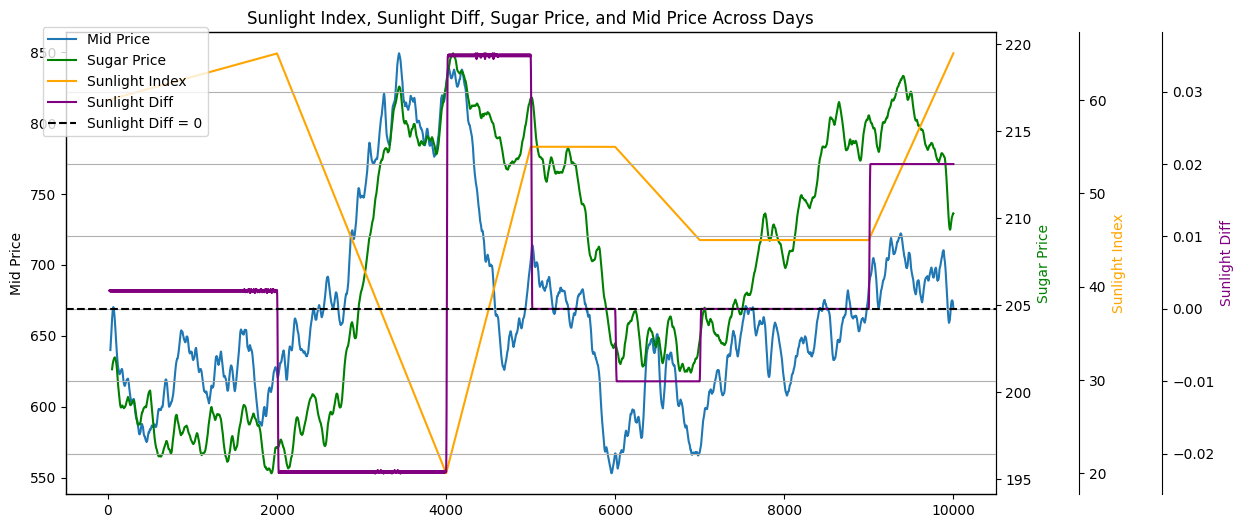

In [ ]:
def plot_components_with_sunlight_diff(comp1, comp2, comp3, sunlight, sunlight_diff):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()

    # Offset the third and fourth axes to avoid overlap
    ax3.spines['right'].set_position(('outward', 60))
    ax4.spines['right'].set_position(('outward', 120))

    ax1.plot(comp1.index, comp1, label='Mid Price')
    ax2.plot(comp2.index, comp2, label='Sugar Price', color='green')
    ax3.plot(comp3.index, comp3, label='Sunlight Index', color='orange')
    ax4.plot(sunlight_diff.index, sunlight_diff, label='Sunlight Diff', color='purple')

    # Draw a black line where sunlight diff is zero
    ax4.axhline(0, color='black', linestyle='--', label='Sunlight Diff = 0')

    plt.xlabel('time')
    ax1.set_ylabel('Mid Price')
    ax2.set_ylabel('Sugar Price', color='green')
    ax3.set_ylabel('Sunlight Index', color='orange')
    ax4.set_ylabel('Sunlight Diff', color='purple')

    plt.title('Sunlight Index, Sunlight Diff, Sugar Price, and Mid Price Across Days')
    plt.xticks(rotation=45)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.grid()
    plt.show()

# Example usage
plot_components_with_sunlight_diff(
    sma, 
    data['sugarPrice'].rolling(50).mean(), 
    data['sunlightIndex'], 
    data['sunlightIndex'], 
    data['sunlightIndex'].diff().rolling(10).mean().rolling(10).mean()
)

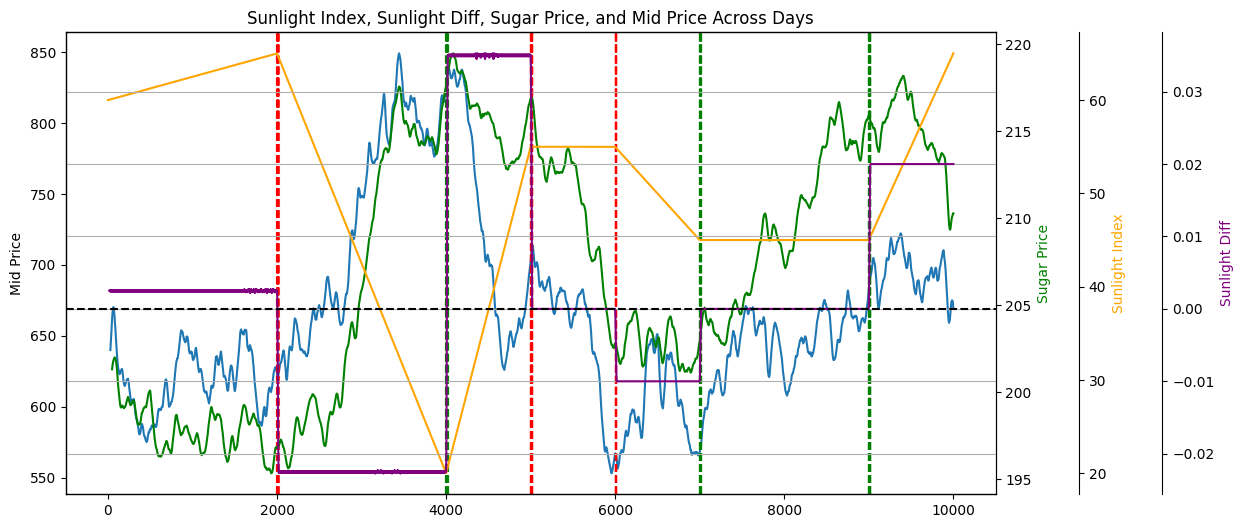

In [145]:
def plot_components_with_sunlight_diff(comp1, comp2, comp3, sunlight, sunlight_diff, dot_dot_sunlight, inflection_threshold = 0.001):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()

    # Offset the third and fourth axes to avoid overlap
    ax3.spines['right'].set_position(('outward', 60))
    ax4.spines['right'].set_position(('outward', 120))

    ax1.plot(comp1.index, comp1, label='Mid Price')
    ax2.plot(comp2.index, comp2, label='Sugar Price', color='green')
    ax3.plot(comp3.index, comp3, label='Sunlight Index', color='orange')
    ax4.plot(sunlight_diff.index, sunlight_diff, label='Sunlight Diff', color='purple')

    # Draw a black line where sunlight diff is zero
    ax4.axhline(0, color='black', linestyle='--', label='Sunlight Diff = 0')

    # Plot vertical lines at inflection points
    for idx in dot_dot_sunlight.dropna().index:
    # for idx in dot_dot_sunlight.dropna().index:
        if dot_dot_sunlight[idx] > inflection_threshold:  # Positive inflection point
            ax1.axvline(x=idx, color='green', linestyle='--', alpha=0.7, label='Positive Inflection Point')
        elif dot_dot_sunlight[idx] < -inflection_threshold:  # Negative inflection point
            ax1.axvline(x=idx, color='red', linestyle='--', alpha=0.7, label='Negative Inflection Point')

    plt.xlabel('time')
    ax1.set_ylabel('Mid Price')
    ax2.set_ylabel('Sugar Price', color='green')
    ax3.set_ylabel('Sunlight Index', color='orange')
    ax4.set_ylabel('Sunlight Diff', color='purple')

    plt.title('Sunlight Index, Sunlight Diff, Sugar Price, and Mid Price Across Days')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


sunlight_smooth = data['sunlightIndex'].diff().rolling(10).mean().rolling(10).mean()

# Example usage
plot_components_with_sunlight_diff(
    sma, 
    data['sugarPrice'].rolling(50).mean(), 
    data['sunlightIndex'], 
    data['sunlightIndex'], 
    data['sunlightIndex'].diff().rolling(10).mean().rolling(10).mean(),
    sunlight_smooth.diff(2),
)

In [147]:
def hysteresis_inflections(series, high_thresh=0.001, low_thresh=0.0005, spacing=5):
    dot_dot = series.dropna()
    idxs = dot_dot.index
    values = dot_dot.values

    signals = []
    can_signal_pos = True
    can_signal_neg = True

    for i in range(len(values)):
        val = values[i]
        idx = idxs[i]

        if can_signal_pos and val > high_thresh:
            signals.append(('positive', idx))
            can_signal_pos = False  # turn off until we fall below low_thresh
        elif val < low_thresh:
            can_signal_pos = True

        if can_signal_neg and val < -high_thresh:
            signals.append(('negative', idx))
            can_signal_neg = False
        elif val > -low_thresh:
            can_signal_neg = True

    return pd.Series(signals)

# plot_components_with_sunlight_diff(
#     sma, 
#     data['sugarPrice'].rolling(50).mean(), 
#     data['sunlightIndex'], 
#     data['sunlightIndex'], 
#     data['sunlightIndex'].diff().rolling(10).mean().rolling(10).mean(),
#     hysteresis_inflections(sunlight_smooth.diff(2)),
# )

hysteresis_inflections(sunlight_smooth.diff(2)),

(0    (negative, 2003)
 1    (positive, 4002)
 2    (negative, 5003)
 3    (negative, 6004)
 4    (positive, 7004)
 5    (positive, 9001)
 dtype: object,)

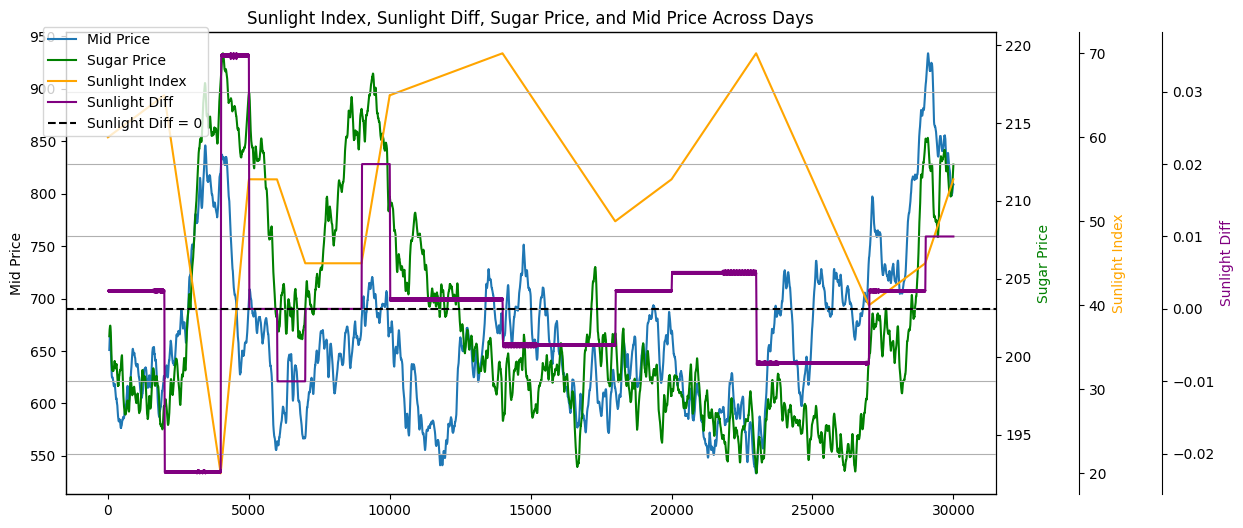

In [119]:
plot_components_with_sunlight_diff(
    mk['mid_price'].rolling(50).mean(), 
    mk['sugarPrice'].rolling(50).mean(), 
    mk['sunlightIndex'], 
    mk['sunlightIndex'], 
    mk['sunlightIndex'].diff().rolling(10).mean().rolling(10).mean()
)

In [ ]:
'''
STRAT

depends on sunlight derivative (smoothed out with double rolling mean)

threshold is 0.02

if diff >= threshold:
    short
if diff <= threshold:
    long

if diff within clear thresholds:
    clear, market make / take

have to define these locations where regime switch occurs

when sunlight goes from positve to negative by significant amount or vice-versa

when slope changes

'''

<Axes: >

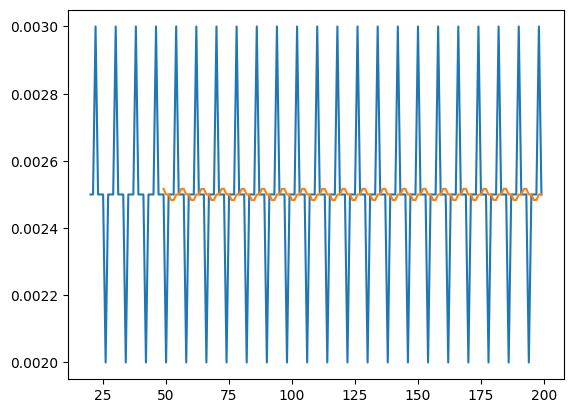

In [116]:
data['sunlightIndex'].diff().rolling(20).mean()[:200].plot()
data['sunlightIndex'].diff().rolling(20).mean().rolling(30).mean()[:200].plot()

In [ ]:
'''
if sunlight goes below CSI and ANTICIPATED to remain below then prices go up

what does anticipation mean here? the bots are smart and will anticipate remaining below CSI for a while?

is this change sudden or gradual at threshold?

is it a static csi level or is the change gradual?

if it's static, just would have to find this static threshold

if gradual then this gets harder


visual guess for threshold is 50



some ideas:

- try restric CSI to certain values under / above guess threshold and check if correlation is good
- if below CSI then


it seems sunlight slope has the higest impact, proably also depends on constant at the beginning as well though
'''